#### Test RS knn with cosine distance on mean centered data, evaluating with RSME and MAE

In [90]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
import seaborn as sns
from reco_systems.evaluation import *
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# import DB et set min_reviews
folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"trictrac_database/users.csv", names=["Username", "User id"])

min_reviews = 5

In [36]:
# filter data with the minimum reviews
filtered_data = filter_df(avis_clean, min_reviews)

# we center the ratings for the centered cos version
filtered_centrd_data, avg_df = center_score(filtered_data)

11201 10549
3242 3957
3006 3910
3003 3910


In [43]:
# get the needed matrixes

# matrix_ratings : sparse matrix for nonzero values only: row = users, cols = games
# mask_ratings : mask for NaN values only -> with matrix_ratings, can get ratings = 0
# users/games_table_assoc : association index - ids for the matrix_use

matrix_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(filtered_centrd_data)
users_table_assoc

0           0
1           1
2           2
3           3
4           4
        ...  
2998    10628
2999    10685
3000    10686
3001    10713
3002    10775
Name: User id, Length: 3003, dtype: int64

In [ ]:
# we calculate the similarity matrix with cos on the centered values
similarity_matrix, _ = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")

# cosine similarity range [-1,1] cosine distance = 1 - similarity, range [0, 2] 
np.unique(similarity_matrix) 

array([0.        , 0.04441922, 0.09306476, ..., 1.86065469, 1.86281226,
       1.86330066], shape=(990595,))

In [48]:
# for the evaluation, we test on the X most popular users (by number of reviews) 
users_count = filtered_centrd_data[["User id", "Game id"]].groupby("User id", as_index=True).count().sort_values(by="Game id", ascending=False).head(200)

# get the index (matrix) associated to the selected users ids
users = users_table_assoc[users_table_assoc.isin(users_count.index)].index.to_numpy()
type(users)

numpy.ndarray

#### **RMSE** 

In [79]:
vect_rmse = np.vectorize(calc_RMSE_cos, excluded=['matrix_ratings', 'mask_ratings', 'similarity_matrix'])
result = vect_rmse(users, matrix_ratings=matrix_ratings, mask_ratings=mask_ratings, similarity_matrix=similarity_matrix)

In [55]:
# rsme calculated for each users, RMSE can be above 10
np.unique(result)

array([ 2.56645493,  2.6798081 ,  2.93240703,  2.96228345,  3.08839576,
        3.14890903,  3.21392214,  3.32080033,  3.3736926 ,  3.52686225,
        3.53485539,  3.5491225 ,  3.5869249 ,  3.61857819,  3.62065541,
        3.69042835,  3.69916425,  3.73777543,  3.77988264,  3.82536553,
        3.8695939 ,  3.89194024,  3.92985872,  3.94101436,  3.96021973,
        3.97754883,  3.98694746,  4.06194742,  4.10611068,  4.12225802,
        4.17150181,  4.17569743,  4.22377093,  4.25859451,  4.28082216,
        4.28489435,  4.2930152 ,  4.3230792 ,  4.33172362,  4.35192465,
        4.35535713,  4.36268312,  4.37291575,  4.39582766,  4.40145588,
        4.41734968,  4.42045885,  4.4294695 ,  4.43627726,  4.47751346,
        4.47796989,  4.49401791,  4.49627725,  4.54969245,  4.57119212,
        4.57328259,  4.59288171,  4.59289329,  4.66994145,  4.67979376,
        4.68594282,  4.68744204,  4.7229376 ,  4.80112586,  4.82034478,
        4.83516739,  4.85546625,  4.86819166,  4.89364351,  4.91

In [84]:
# users_table_assoc[users] = true id of users
# we associate each users with their RMSE and count reviews
rmse_users = pd.DataFrame(zip(users_table_assoc[users], result), columns=["User id", "RMSE"]).merge(users_count, on ="User id")
rmse_users.columns = ["User id", "RMSE", "Count reviews"]
rmse_users.sort_values(by="Count reviews", inplace=True)
rmse_users

,User id,RMSE,Count reviews
86,1195,7.262888,128
133,1919,6.095311,128
154,2246,4.523937,129
41,364,4.169880,129
165,2282,3.903801,129
...,...,...,...
33,201,4.443777,702
11,91,4.716027,764
8,83,5.222101,921
0,1,6.140598,970


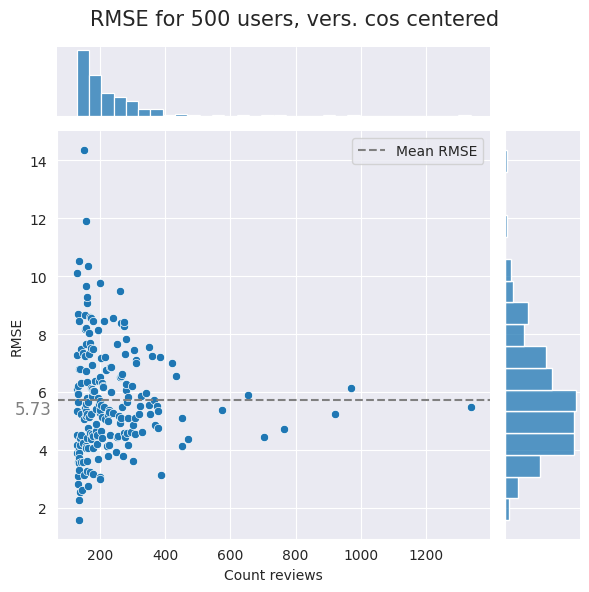

In [85]:
# we plot the RMSE distribution for cos

sns.set_style("darkgrid")
plot = sns.jointplot(data=rmse_users, x="Count reviews", y="RMSE", kind="scatter")
plot.ax_joint.axhline(rmse_users["RMSE"].mean(), color="gray", linestyle="--", label="Mean RMSE")
plot.ax_joint.text(x=50, y=rmse_users["RMSE"].mean() - 0.5, s=f'{round(rmse_users["RMSE"].mean(), 2)}', color='gray', fontsize=12, ha='right')
plot.figure.suptitle('RMSE for 500 users, vers. cos centered', fontsize=15)
plot.figure.tight_layout()
plot.ax_joint.legend()


In [86]:
# normalized RMSE 
rmse_users['Normalized RMSE'] = (rmse_users['RMSE'] - rmse_users['RMSE'].min()) / (rmse_users['RMSE'].max() - rmse_users['RMSE'].min())
rmse_users

,User id,RMSE,Count reviews,Normalized RMSE
86,1195,7.262888,128,0.445078
133,1919,6.095311,128,0.353822
154,2246,4.523937,129,0.231004
41,364,4.169880,129,0.203332
165,2282,3.903801,129,0.182535
...,...,...,...,...
33,201,4.443777,702,0.224739
11,91,4.716027,764,0.246018
8,83,5.222101,921,0.285572
0,1,6.140598,970,0.357361


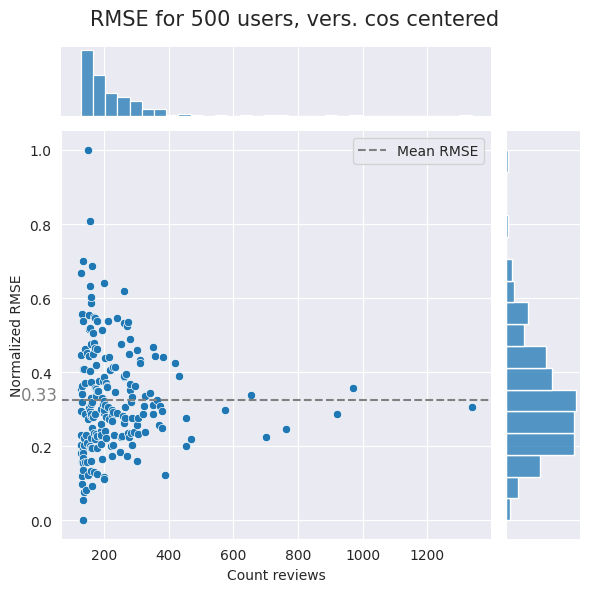

In [87]:
# we plot the RMSE normalized distribution

sns.set_style("darkgrid")
plot = sns.jointplot(data=rmse_users, x="Count reviews", y="Normalized RMSE", kind="scatter")
plot.ax_joint.axhline(rmse_users["Normalized RMSE"].mean(), color="gray", linestyle="--", label="Mean RMSE")
plot.ax_joint.text(x=0, y=rmse_users["Normalized RMSE"].mean(), s=f'{round(rmse_users["Normalized RMSE"].mean(), 2)}', color='gray', fontsize=12, ha='center')
plot.figure.suptitle('RMSE for 500 users, vers. cos centered', fontsize=15)
plot.figure.tight_layout()
plot.ax_joint.legend()

#### **MAE**

In [92]:
vect_mae = np.vectorize(calc_MAE_cos, excluded=['matrix_ratings', 'mask_ratings', 'similarity_matrix'])
result = vect_mae(users, matrix_ratings=matrix_ratings, mask_ratings=mask_ratings, similarity_matrix=similarity_matrix)

In [95]:
# users_table_assoc[users] = true id of users
# we associate each users with their MAE and count reviews
rmse_users = pd.DataFrame(zip(users_table_assoc[users], result), columns=["User id", "MAE"]).merge(users_count, on ="User id")
rmse_users.columns = ["User id", "MAE", "Count reviews"]
rmse_users.sort_values(by="Count reviews", inplace=True)
# normalized MAE 
rmse_users['Normalized MAE'] = (rmse_users['MAE'] - rmse_users['MAE'].min()) / (rmse_users['MAE'].max() - rmse_users['MAE'].min())
rmse_users

,User id,MAE,Count reviews,Normalized MAE
86,1195,1.927343,128,0.447928
133,1919,1.745070,128,0.346827
154,2246,1.809332,129,0.382472
41,364,2.715793,129,0.885254
165,2282,1.932866,129,0.450992
...,...,...,...,...
33,201,1.707823,702,0.326168
11,91,1.865071,764,0.413388
8,83,1.750279,921,0.349717
0,1,1.763838,970,0.357237


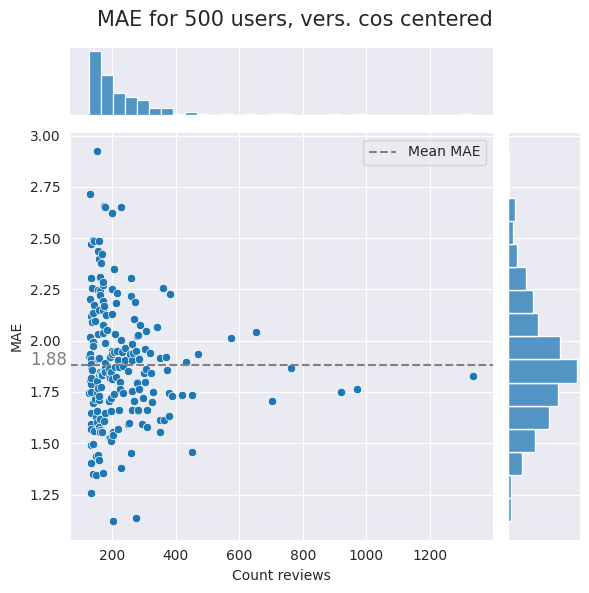

In [96]:
# we plot the RMSE normalized distribution

sns.set_style("darkgrid")
plot = sns.jointplot(data=rmse_users, x="Count reviews", y="MAE", kind="scatter")
plot.ax_joint.axhline(rmse_users["MAE"].mean(), color="gray", linestyle="--", label="Mean MAE")
plot.ax_joint.text(x=0, y=rmse_users["MAE"].mean(), s=f'{round(rmse_users["MAE"].mean(), 2)}', color='gray', fontsize=12, ha='center')
plot.figure.suptitle('MAE for 500 users, vers. cos centered', fontsize=15)
plot.figure.tight_layout()
plot.ax_joint.legend()

##### Remarks
##### The MAE and RMSE were computed on different predicted games for the same users, aka need to get the predicted ratings and compute separately errors to see the differences, not all in one function